In [ ]:
import re
import pandas as pd
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import nltk

## 1. Генерирование русских имен при помощи RNN

Датасет: https://disk.yandex.ru/i/2yt18jHUgVEoIw

1.1 На основе файла name_rus.txt создайте датасет.
  * Учтите, что имена могут иметь различную длину
  * Добавьте 4 специальных токена:
    * `<PAD>` для дополнения последовательности до нужной длины;
    * `<UNK>` для корректной обработки ранее не встречавшихся токенов;
    * `<SOS>` для обозначения начала последовательности;
    * `<EOS>` для обозначения конца последовательности.
  * Преобразовывайте строку в последовательность индексов с учетом следующих замечаний:
    * в начало последовательности добавьте токен `<SOS>`;
    * в конец последовательности добавьте токен `<EOS>` и, при необходимости, несколько токенов `<PAD>`;
  * `Dataset.__get_item__` возращает две последовательности: последовательность для обучения и правильный ответ.
  
  Пример:
  ```
  s = 'The cat sat on the mat'
  # преобразуем в индексы
  s_idx = [2, 5, 1, 2, 8, 4, 7, 3, 0, 0]
  # получаем x и y (__getitem__)
  x = [2, 5, 1, 2, 8, 4, 7, 3, 0]
  y = [5, 1, 2, 8, 4, 7, 3, 0, 0]
  ```

1.2 Создайте и обучите модель для генерации фамилии.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`;
  * Используйте рекуррентные слои;
  * Задача ставится как предсказание следующего токена в каждом примере из пакета для каждого момента времени. Т.е. в данный момент времени по текущей подстроке предсказывает следующий символ для данной строки (задача классификации);
  * Примерная схема реализации метода `forward`:
  ```
    input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
    emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
    output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
    output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
  ```

1.3 Напишите функцию, которая генерирует фамилию при помощи обученной модели:
  * Построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * Начальное скрытое состояние RNN `h_t = None`;
  * В результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * Выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * Повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности.

При обучении каждые `k` эпох генерируйте несколько фамилий и выводите их на экран.

## 1.1

In [ ]:
class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.seq_len = names.str.len().max()
        self.vocab = vocab

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        tokens = list(self.names.iloc[idx])
        tokens = [token if token in self.vocab else self.vocab.unk_idx
                  for token in tokens]
        pad_count = self.seq_len - len(tokens)
        tokens = vocab(tokens) + [self.vocab.pad_idx] * pad_count
        x = [self.vocab.sos_idx] + tokens
        y = tokens + [self.vocab.eos_idx]
        return torch.tensor(x), torch.tensor(y)

## 1.2

In [ ]:
class NamesNet(pl.LightningModule):
    def __init__(self, dataset, vocab, embedding_size,
                 hidden_size, batch_size, lr):
        super().__init__()

        self.save_hyperparameters(ignore=['dataset', 'vocab'])

        self.dataset = dataset
        self.vocab = vocab

        self.loss_history = []

        self.embedding = nn.Embedding(
            num_embeddings=len(vocab),
            embedding_dim=embedding_size
        )
        self.rnn = nn.RNN(
            input_size=embedding_size, hidden_size=hidden_size,
            batch_first=True
        )
        self.linear = nn.Linear(
            in_features=hidden_size, out_features=len(vocab)
        )

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        output = output.reshape(-1, output.size(2))
        output = self.linear(output)
        return output, hidden

    def generate(self, max_len=10):
        name = []
        current_token = torch.tensor([[self.vocab.sos_idx]])
        hidden = None

        for _ in range(max_len):
            output, hidden = self(current_token, hidden)
            output = output.squeeze()
            probabilities = torch.softmax(output, dim=0)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            if next_token == self.vocab.eos_idx:
                break

            if next_token not in (self.vocab.pad_idx,
                                  self.vocab.sos_idx,
                                  self.vocab.unk_idx):
                name.append(self.vocab.lookup_token(next_token))

            current_token = torch.tensor([[next_token]])

        return ''.join(name).capitalize()

    def train_dataloader(self):
        return DataLoader(
            self.dataset, batch_size=self.hparams.batch_size, shuffle=True)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits, hidden = self(x)
        y = y.reshape(-1)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('loss', loss, on_step=True, prog_bar=True)
        self.loss_history.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        names = [self.generate() for _ in range(15)]
        names = ', '.join(names)
        print(f'Epoch: {self.current_epoch}, names: {names}')

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), lr=self.hparams.lr)
        return optimizer

    def plot_learning_curve(self):
        plt.plot(self.loss_history)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.show()

## 1.3

In [ ]:
vocab = build_vocab_from_iterator(names['name'])
vocab.UNK = '<UNK>'
vocab.PAD = '<PAD>'
vocab.SOS = '<SOS>'
vocab.EOS = '<EOS>'
vocab.append_token(vocab.UNK)
vocab.append_token(vocab.PAD)
vocab.append_token(vocab.SOS)
vocab.append_token(vocab.EOS)
vocab.unk_idx = vocab[vocab.UNK]
vocab.pad_idx = vocab[vocab.PAD]
vocab.sos_idx = vocab[vocab.SOS]
vocab.eos_idx = vocab[vocab.EOS]
vocab.set_default_index(vocab.unk_idx)

In [ ]:
path = r'/content/name_rus.txt'
names = pd.read_csv(path, names=['name'], encoding='1251')
names.head()

,name
0,авдокея
1,авдоким
2,авдоня
3,авдотька
4,авдотьюшка


In [ ]:
dataset = NamesDataset(names['name'])

In [ ]:
net = NamesNet(dataset, vocab, embedding_size=256, hidden_size=512,
               batch_size=128, lr=0.0005)
trainer = pl.Trainer(accelerator='cpu', max_epochs=25)
trainer.fit(net)

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO: 
  | Name      | Type      | Params
----------------------------------------
0 | vocab     | Vocab     | 0     
1 | embedding | Embedding | 8.7 K 
2 | rnn       | RNN       | 394 K 
3 | linear    | Linear    | 17.4 K
----------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Tota

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, names: Микирца, Юмзэтевюым, Яйнхакфя, Линжша, Доперючев, Эжецжвшчлы, Пюожтурмдр, Гоня, Някьт, Данава, Зчвя, Таранилин, Оан, Йвйыймити, Иана
Epoch: 1, names: Алариыота, Мервха, Венпмфн, Тавуся, Намахяна, Моонванра, Шактря, Горика, Кансята, Милича, Еьюня, Ваонян, Ннбу, Лотюша, Лелинкаша
Epoch: 2, names: Ситта, Ласусяха, Иуея, Ма, Нида, Ледека, Еосуйвалит, Еымарсико, Па, Генчша, Илофка, Гешарю, Уика, Елетач, Пева
Epoch: 3, names: Муся, Деонагыч, Малека, Аалуша, Насебся, Денчха, Диноыч, Витюха, Авгуля, Етарока, А, Гатисита, Анрона, , Ауля
Epoch: 4, names: Самилина, Енгльянкк, Дамашка, Уронюша, Нарсян, Карьилич, Виликня, Сируха, Эфтойа, Рипьтий, Рося, Стехуна, Каля, Арсраья, Эфкока
Epoch: 5, names: Дена, Леооня, Алиниса, Варля, Коня, Метюха, Елеья, Жлена, Эртумя, Каля, Гелюдя, Коксюля, Нилюлидма, Манюха, Эука
Epoch: 6, names: Митрич, Мароныч, Герисин, Алянюха, Еедьанма, Поттилыч, Патстюха, Аниса, Марим, Тормюй, Ипкарин, Оуля, Марияниа, Гаря, Евита
Epoch: 7, names: Далляка, Фледгри

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch: 24, names: Киюнич, Антонн, Евяод, Рота, Тията, Буря, Вадим, Гамуля, Натуня, Игора, Таняра, Анерола, Шуня, Шурасюша, Игеря


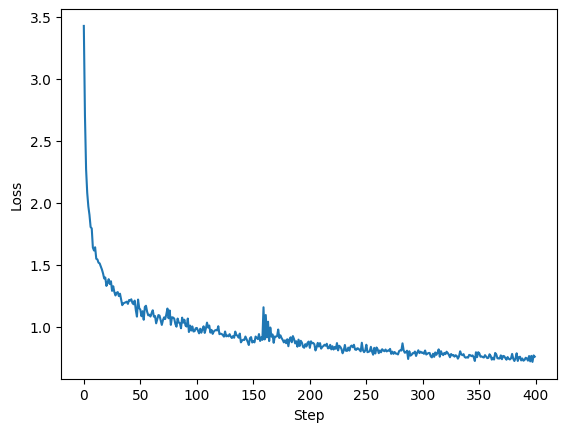

In [ ]:
net.plot_learning_curve()

## 2. Генерирование текста при помощи RNN

2.1 Скачайте из интернета какое-нибудь художественное произведение
  * Выбирайте достаточно крупное произведение, чтобы модель лучше обучалась;

2.2 На основе выбранного произведения создайте датасет.

Отличия от задачи 1:
  * Токены <SOS>, `<EOS>` и `<UNK>` можно не добавлять;
  * При создании датасета текст необходимо предварительно разбить на части. Выберите желаемую длину последовательности `seq_len` и разбейте текст на построки длины `seq_len` (можно без перекрытия, можно с небольшим перекрытием).

2.3 Создайте и обучите модель для генерации текста
  * Задача ставится точно так же как в 1.2;
  * При необходимости можете применить:
    * двухуровневые рекуррентные слои (`num_layers`=2)
    * [обрезку градиентов](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

2.4 Напишите функцию, которая генерирует фрагмент текста при помощи обученной модели
  * Процесс генерации начинается с небольшого фрагмента текста `prime`, выбранного вами (1-2 слова)
  * Сначала вы пропускаете через модель токены из `prime` и генерируете на их основе скрытое состояние рекуррентного слоя `h_t`;
  * После этого вы генерируете строку нужной длины аналогично 1.3


In [ ]:
with open('/content/war_peace_plain.txt') as file:
    text = file.read()
text = text.replace('\n', ' ')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokens = []
for sentence in nltk.sent_tokenize(text):
    tokens.extend(['<SOS>'] + list(sentence))

In [ ]:
seq_len = 100
overlap = 10
parts = []

start = 0
while start < len(tokens):
    part = tokens[start:start + seq_len]
    parts.append(part)
    start += seq_len - overlap

In [ ]:
vocab = build_vocab_from_iterator(parts)
vocab.append_token('<PAD>')
vocab.pad_idx = vocab['<PAD>']
vocab.sos_idx = vocab['<SOS>']

In [ ]:
class WarAndPeaceDataset(Dataset):
    def __init__(self, parts, vocab):
        self.parts = parts
        self.seq_len = max(
            [len(tokens) for tokens in parts])
        self.vocab = vocab

    def __len__(self):
        return len(parts)

    def __getitem__(self, idx):
        tokens = self.parts[idx]
        pad_count = self.seq_len - len(tokens)
        tokens = vocab(tokens) + [self.vocab.pad_idx] * pad_count
        x = [self.vocab.sos_idx] + tokens
        next_token = self.vocab.pad_idx
        if idx != len(self) - 1:
            next_token = vocab(self.parts[idx + 1])[0]
        y = tokens + [next_token]
        return torch.tensor(x), torch.tensor(y)

In [ ]:
dataset = WarAndPeaceDataset(parts, vocab)

In [ ]:
class WarAndPeaceNet(pl.LightningModule):
    def __init__(self, dataset, vocab, embedding_size,
                 hidden_size, num_layers, batch_size, lr):
        super().__init__()

        self.save_hyperparameters(ignore=['dataset', 'vocab'])

        self.dataset = dataset
        self.vocab = vocab

        self.loss_history = []

        self.embedding = nn.Embedding(
            num_embeddings=len(vocab),
             =embedding_size
        )
        self.rnn = nn.LSTM(
            input_size=embedding_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        self.linear = nn.Linear(
                in_features=hidden_size, out_features=len(vocab))

    def forward(self, x, hidden=None, cell=None):
        embedded = self.embedding(x)
        if hidden is not None:
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        else:
            output, (hidden, cell) = self.rnn(embedded)
        output = output.reshape(-1, output.size(2))
        output = self.linear(output)
        return output, (hidden, cell)

    def generate(self, prime, max_len=100, temperature=1.0):
        tokens = list(prime)
        prime_idxs = [self.vocab.sos_idx] + self.vocab.lookup_indices(tokens)
        last_prime_idx = prime_idxs[-1]
        prime_idxs = torch.tensor([prime_idxs]).to(self.device)
        output, (hidden, cell) = self(prime_idxs)
        current_token = torch.tensor(
            [[last_prime_idx]]).to(self.device)

        for _ in range(max_len - len(prime)):
            output, (hidden, cell) = self(current_token, hidden, cell)
            output = output.squeeze()
            probabilities = torch.softmax(output / temperature, dim=0)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()
            current_token = torch.tensor([[next_token]]).to(self.device)

            if next_token not in (self.vocab.pad_idx,
                                  self.vocab.sos_idx):
                tokens.append(self.vocab.lookup_token(next_token))

        return ''.join(tokens)

    def train_dataloader(self):
        return DataLoader(
            self.dataset, batch_size=self.hparams.batch_size, shuffle=True)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits, (hidden, cell) = self(x)
        y = y.reshape(-1)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('loss', loss, on_step=True, prog_bar=True)
        self.loss_history.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        print(f'Epoch: {self.current_epoch}, '
              f'text: {self.generate("Prince Andrew ", max_len=250)}')
        print()

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=5, gamma=0.1)
        return [optimizer], [lr_scheduler]

    def plot_learning_curve(self):
        plt.plot(self.loss_history)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.show()

In [ ]:
net = WarAndPeaceNet(dataset, vocab, embedding_size=4096, hidden_size=512,
                     num_layers=2, batch_size=256, lr=0.001)
trainer = pl.Trainer(accelerator='auto', max_epochs=10)
trainer.fit(net)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type      | Params
----------------------------------------
0 | vocab     | Vocab     | 0     
1 | embedding | Embedding | 430 K 
2 | rnn       | LSTM      | 11.5 M
3 | linear    | Linear    | 53.9 K
----------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
48.106    Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, text: Prince Andrew had gorawed her oull thable.In seess have Kuirúty...””  “No tured whilhon asked to beay Kusich  much, lou forhing refrouch Alsissaile.Betoree up beared their with runse, and leared of the wase notretilinothing the come has pacttoauntu

Epoch: 1, text: Prince Andrew Some heor he Rishat French ressumentaraled maner and fairr’s rzenced, Borís Baught, whuncess hos browddeth—thismisisse PlaRssal or a strainty o“f actilivid, now to up no musting forse disnimentantly himself.Ancame at his same to be fro

Epoch: 2, text: Prince Andrew com!” was becausely or I ord the pause and not meether in a but no imptinu?” .When hat Rostóv show I trung.The staff clead with a finished Priech God.The Ruslid; rearienty-him—sittend that attectioned from to her hand to to that wits

Epoch: 3, text: Prince Andrew spoke dual wantion to him.‘Valask, as the life and ocials, and cast constivity amost his one no talk, and in tailing shoutant of a we of lifkere.The ville be the hand with 

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


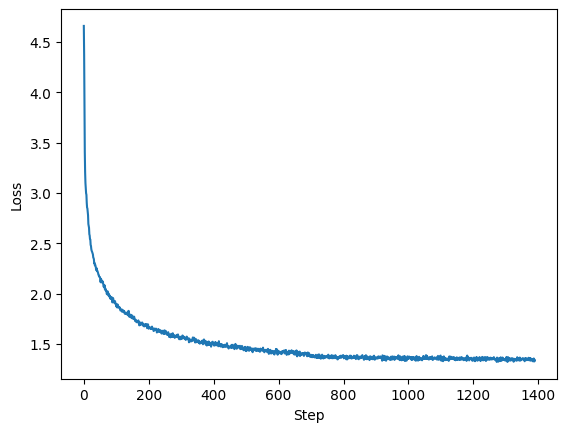

In [ ]:
net.plot_learning_curve()

In [ ]:
print(net.generate('Sonya was a slender little brunette ', max_len=500, temperature=0.5))

Sonya was a slender little brunette his head and were seemed to the retire no longer to his words and the other who had to do began to his special to day of the pronce of the army of the count of the soldiers and the count was frightened to his was and the began experienced in an events of the wold ban was a man who was not about to have been rubbing to a staff of the prince who had sent the man with the words of the man who was not seemed to battle with the sounds of the prince than one standin
